In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
%matplotlib inline
import datetime
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

Now that we have all of this New York Times and Twitter text scraped, in this case stretching back until the start of 2016, along with stock data, and processed into well formatted dataframes/CSVs, we can begin to explore and try to tease out what sort of connection, if any, there is between the sentiment scores and the stock performance.

If you have any familiarity with the financial realm you may have warranted skepticism that today's sentiment can reveal anything useful about the movement of the price tomorrow in a systemic way. And indeed, if you chart the stock price next to one source of sentiment, the results look noisey and not super compelling:

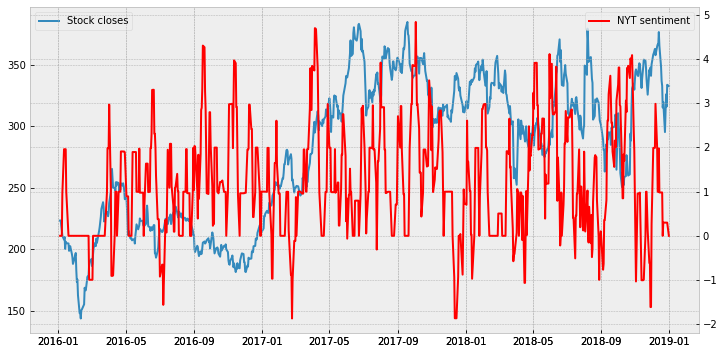

In [8]:
#read in data frame, fix index and set to date time
tesla_master = pd.read_csv('tesla_master.csv')
tesla_master['date'] =  pd.to_datetime(tesla_master['date'])
tesla_master.set_index('date', inplace=True)
#My NYT/twitter data doesn't go all the way to the present, so trimming the dataframe a little
tesla_master = tesla_master['2019-07-01':]

#create a rolling sentiment value for chart clarity
tesla_master['rolling_sentiment'] = tesla_master['nyt_compound'].rolling(window=5).sum()

#plot out stock closes vs this rolling sentiment
fig1 = plt.figure(figsize=(12,6))
ax1 = fig1.add_subplot(111)
ax1.plot(tesla_master['2018':'2016']['4. close'],label = 'Stock closes')
plt.legend(loc='upper left')
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
ax2.plot(tesla_master['2018':'2016']['rolling_sentiment'], label='NYT sentiment', color='r')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.legend()

This looks messy and unhelpful, but it's a little misleading. In order to keep the swings in sentiment scores from taking up so much visual space, I've plotted a rolling sum of the sentiment, but this can obscure some of the day to day links.

It is also hard to see from this graph whether or not there are any sort of critical values - perhaps only the extreme values of sentiment are linked to clear movements in stock price.

Let's consider what sort of stock movements follow days with different degrees of sentiment:

In [44]:
print('Average day change: ',round(tesla_master['day_change'].mean(),5))
#using a cut off of positive and negative .05 to avoid dates with no NYT articles (which have 0 values)
#and days that seem roughly balanced between negative and positive articles
print('Day change following high sentiment: ',
      round(tesla_master[tesla_master['nyt_compound'] > .05]['day_change'].mean(),5))
print('Day change following low sentiment: ',
      round(tesla_master[tesla_master['nyt_compound'] < -.05]['day_change'].mean(),5))

Average day change:  0.00042
Day change following high sentiment:  0.00234
Day change following low sentiment:  -0.00429


Over the three and a half years of this data frame, there was a clear bounce following positive sentiment. On average the daily stock movement was low, but positive - around .04%. This should make some sense. Over the entire time period the stock price did rise, but with that rise spread out over so much time, the average day to day movement is pretty low.

Following a high sentiment value in the NYT, however, we see day to day movement of closer a bit more than .2% on average and following low sentiment in the NYT we see a drop of a bit more than .4% on average.

It ought to be said that these are small differences and that the averages are masking substantial variance within the groups - there are definitely instances of low sentiment days being followed by price increases and vice versa. Visually suggestive as these numbers are, the differences between these two groups is not quite statistically significant.

Something else of interest is that any effects that may be here seem non-linear. Consider a further breakdown that now brings in the negativity score from Twitter:

In [49]:
print('Average day change: ',round(tesla_master['day_change'].mean(),5))
print('Day change following high NYT sentiment, high Twitter negativity: ',
      round(tesla_master[(tesla_master['nyt_compound'] > .05)&(tesla_master['twitter_neg'] > .06)]['day_change'].mean(),5))
print('Day change following high NYT sentiment, low Twitter negativity: ',
      round(tesla_master[(tesla_master['nyt_compound'] > .05)&(tesla_master['twitter_neg'] < .04)]['day_change'].mean(),5))
print()
print('Day change following low NYT sentiment, high Twitter negativity: ',
      round(tesla_master[(tesla_master['nyt_compound'] < -.05)&(tesla_master['twitter_neg'] > .06)]['day_change'].mean(),5))
print('Day change following low NYT sentiment, low Twitter negativity: ',
      round(tesla_master[(tesla_master['nyt_compound'] < -.05)&(tesla_master['twitter_neg'] < .04)]['day_change'].mean(),5))


Average day change:  0.00042
Day change following high NYT sentiment, high Twitter negativity:  0.00359
Day change following high NYT sentiment, low Twitter negativity:  0.0016

Day change following low NYT sentiment, high Twitter negativity:  -0.01718
Day change following low NYT sentiment, low Twitter negativity:  0.01081


Between days with high and low negativity scores from Twitter, there is a much bigger difference in price movement when the NYT sentiment was low than when it was high. This suggests to me that there is some sort of interaction here and that a linear or logistic regression may not be the most appropriate approach. 

Something else to consider is that given how noisey this all is, trying to estimate the exact price movement is likely not going to be very successful. Maybe that's not an issue though. After all, you don't really need to know the exact amount the stock will go up or down, you just want to know if it will go up to buy or that it will go down to sell. It would probably be more sensible to view this is as a classification problem. Consider:

In [59]:
n_market_days = len(tesla_master)
n_low_sent = len((tesla_master[(tesla_master['nyt_compound'] < -.05)&(tesla_master['twitter_neg'] > .06)]))
low_sent_drop = len((tesla_master[(tesla_master['nyt_compound'] < -.05)&(tesla_master['twitter_neg'] > .06)&(tesla_master['day_change']<0)]))
n_high_sent = len((tesla_master[(tesla_master['nyt_compound'] < -.05)&(tesla_master['twitter_neg'] < .04)]))
high_sent_drop = len((tesla_master[(tesla_master['nyt_compound'] < -.05)&(tesla_master['twitter_neg'] < .04)&(tesla_master['day_change']<0)]))
print('Fraction high negativity days follwed by price drops: ', high_sent_drop/n_high_sent)
print('Fraction low negtativity days follwed by price drops: ', round(low_sent_drop/n_low_sent,1))

Fraction high negativity days follwed by price drops:  0.2
Fraction low negtativity days follwed by price drops:  0.6


How successful can a classification model built entirely on these sentiment scores be? Let's also consider two possible targets: 1) positive or negative day to day growth and 2) positive or negative growth.

One final set of note about how this is set up. One of the biggest challenges was which data should be available to make a given prediction. I ended up taking a relatively conservative approach wherein sentiments gathered EOD for one day would be used to predict the movement for the next day's close. It might make sense to imagine that you could capture intra-day sentiment in a useful way (perhaps a news article is published in the morning before markets open and markets react to it over the day), but I wanted to be very careful to avoid reverse causation wherein the rise or fall in the stock caused a change in sentiment. Perhaps on a day when the stock went up, for instance, you would get a whole series tweets saying things like "wow, the stock really went up!" or an evening news brief mentioning the rise.

For reasons that will become clear, I'm going to start with Netflix, and then turn to Tesla.

In [109]:
netflix_master = pd.read_csv('netflix_master.csv')
netflix_master['date'] =  pd.to_datetime(netflix_master['date'])
netflix_master.set_index('date', inplace=True)
netflix_master = netflix_master['2019-06-28':]

netflix_master['above_average'] = [1 if netflix_master.iloc[n]['day_change']>.0005 else 0 
                                 for n in range(0,len(netflix_master))]
netflix_master['positive_return'] = [1 if netflix_master.iloc[n]['day_change']>.0 else 0 
                                 for n in range(0,len(netflix_master))]

#Our training set will be 2016, 2017 and 2018, then we'll test on the first half of 2019.
features = ['nyt_compound','nyt_pos','nyt_neg','twitter_compound','twitter_pos','twitter_neg']
netflix_X_train = netflix_master['2018':'2016'][features]
netflix_X_test = netflix_master[:'2019'][features]
netflix_y_train = netflix_master['2018':'2016']['above_average']
netflix_y_test = netflix_master[:'2019']['above_average']

param_grid = { 
    'n_estimators': [10,20,30,40,50],
    'criterion': ['gini','entropy'],
    'max_depth': [1,2,3,4,5,6,7,8],
    'min_samples_leaf': [2,3,4,5,6,7,8,9,10]}

rfc = RandomForestClassifier(n_jobs=-1)

#What metric do I target? Either recall (what fraction of true positives are correctly) on the
#assumption that you want a trade to capture every good day? Or maybe precision (what fraction
#of labeled positives are true positives) on the assumption that you want every trade to be
#a winner? Starting with precision
netflix_CV_rfc = GridSearchCV(rfc, param_grid, cv=8,n_jobs=-1,scoring='precision')
netflix_CV_rfc.fit(netflix_X_train, netflix_y_train)
netflix_CV_rfc.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'entropy',
 'max_depth': 1,
 'min_samples_leaf': 6,
 'n_estimators': 10}

In [121]:
#What sort of predictions does this model produce?
netflix_y_pred = netflix_CV_rfc.predict(netflix_X_test)
print('Accuracy: ',accuracy_score(netflix_y_test,netflix_y_pred))
print('Recall: ',recall_score(netflix_y_test,netflix_y_pred))
print('Precision: ',precision_score(netflix_y_test,netflix_y_pred))
print('F1: ',f1_score(netflix_y_test,netflix_y_pred))

Accuracy:  0.5564516129032258
Recall:  0.9393939393939394
Precision:  0.5486725663716814
F1:  0.6927374301675977


Well, these numbers don't exactly look great. Even though I targeted precision my precision value is middling, while recall is quite high. This model clearly captures more of the true positives by being a little free with its guesses and expecting more above average days than not.

But how does it actually perform? Imagine this as an actual trading strategy. Each day, you run the model and if it predicts that tomorrow will be an above average day, you take a $1,000 position on the stock, which you exit at the end of the day (unless the model thinks the following day will also be above average). Would this strategy make you money?

In [122]:
neflix_test_change= netflix_master[:'2019']['day_change']
earnings = 0
for n in range(0,len(netflix_y_pred)):
    if netflix_y_pred[n] == 1:
        earnings += (neflix_test_change.iloc[n]*1000)
earnings

421.34491709130407

The answer is yes, it would make you 420 dollars. Is this good performance? Actually, it's not bad. Consider the simpler strategy of just buying $1,000 dollars worth of Netflix stock at the beginning of the period and holding it until the end. That strategy would also make you money, a similar amount of money, actually.

In [123]:
initial = netflix_master[:'2019']['4. close'][-1]
final = netflix_master[:'2019']['4. close'][0]
(1000/initial)*final - 1000

372.3380407980271

Truth is, these numbers are actually pretty similar, close enough that it's probably not fair to say that this strategy will necessarily beat the market in the long run. In the interest of academic honesty, I'll admit that between my working notebooks and this final, I've run that code a couple of times and depending on the random state of the run, my model doesn't always outperform the simple buy and hold strategy, but so far the numbers have all been pretty close.

Still, it looks like there might be something useful to be gleaned from the sentiment values. For one thing, even if it doesn't beat the market substantially, it gets to its level of performance without taking a position every day. Consider the following graph of stock performance along with vertical lines representing your trades with this strategy:

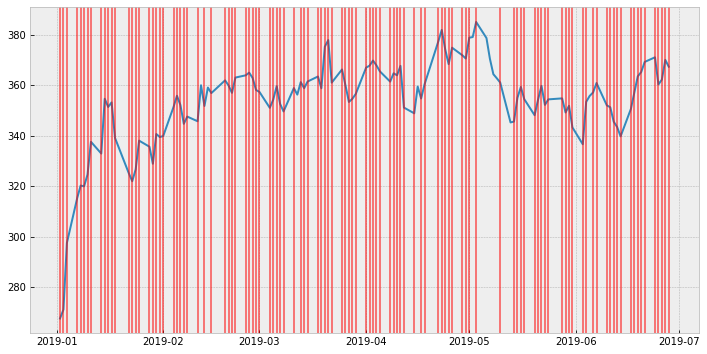

In [124]:
#Collecting the dates for each of these trades by referencing back to the index
trades = []
for n in range(0,len(netflix_y_pred)):
    if netflix_y_pred[n] == 1:
        trades.append(str(netflix_y_test.index[n])[:10])

plt.figure(figsize=(12,6))
plt.plot(netflix_master[:'2019']['4. close'])
for trade in trades:
    plt.axvline(x=[trade], color='r', alpha=.5)

As anticipated, this model takes positions more often than it should, and it will cause you to take positions on days the price drops. But, it manages to beat the buy and hold strategy, particularly by avoiding taking positions during the worst slump at the beginning of May.

And now for Tesla. Code looks much the same, but you'll note that my grid search is now trying to optimize recall - the fraction of true positives that are correctly identified. Why that is will become apparent very shortly.

In [144]:
tesla_master['above_average'] = [1 if tesla_master.iloc[n]['day_change']>.0005 else 0 
                                 for n in range(0,len(tesla_master))]
tesla_master['positive_return'] = [1 if tesla_master.iloc[n]['day_change']>.0 else 0 
                                 for n in range(0,len(tesla_master))]
features = ['nyt_compound','nyt_pos','nyt_neg','twitter_compound','twitter_pos','twitter_neg']
tesla_X_train = tesla_master['2018':'2016'][features]
tesla_X_test = tesla_master[:'2019'][features]
tesla_y_train = tesla_master['2018':'2016']['above_average']
tesla_y_test = tesla_master[:'2019']['above_average']

param_grid = { 
    'n_estimators': [10,20,30,40,50],
    'criterion': ['gini','entropy'],
    'max_depth': [1,2,3,4,5,6,7,8],
    'min_samples_leaf': [2,3,4,5,6,7,8,9,10]}

rfc = RandomForestClassifier(n_jobs=-1)
tesla_CV_rfc = GridSearchCV(rfc, param_grid, cv=8,n_jobs=-1,scoring='recall')
tesla_CV_rfc.fit(tesla_X_train, tesla_y_train)
tesla_CV_rfc.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 9,
 'n_estimators': 10}

In [145]:
tesla_y_pred = tesla_CV_rfc.predict(tesla_X_test)
print('Accuracy: ',accuracy_score(tesla_y_test,tesla_y_pred))
print('Recall: ',recall_score(tesla_y_test,tesla_y_pred))
print('Precision: ',precision_score(tesla_y_test,tesla_y_pred))
print('F1: ',f1_score(tesla_y_test,tesla_y_pred))

Accuracy:  0.496
Recall:  0.08196721311475409
Precision:  0.4166666666666667
F1:  0.136986301369863


These numbers look horrible! This doesn't appear to work at all. Does it make money?

In [146]:
tesla_test_change= tesla_master[:'2019']['day_change']
earnings = 0
for n in range(0,len(tesla_y_pred)):
    if tesla_y_pred[n] == 1:
        earnings += (tesla_test_change.iloc[n]*1000)
earnings

8.703474442509169

It managed to make only $8! But of course we need to compare to the buy and hold strategy...

In [132]:
initial = tesla_master[:'2019']['4. close'][-1]
final = tesla_master[:'2019']['4. close'][0]
(1000/initial)*final - 1000

-267.4771056365279

Yikes! I guess we dodged a bullet and the model works ok...

Tesla's stock has taken a big hit in the first half of 2019. Actually, relative to the simple buy and hold strategy, it looks like the model here is working pretty well. The fact that it keeps you in the black at all is great! It only executes a few trades, and manages not to lose money, even though the stock is down fully 26%

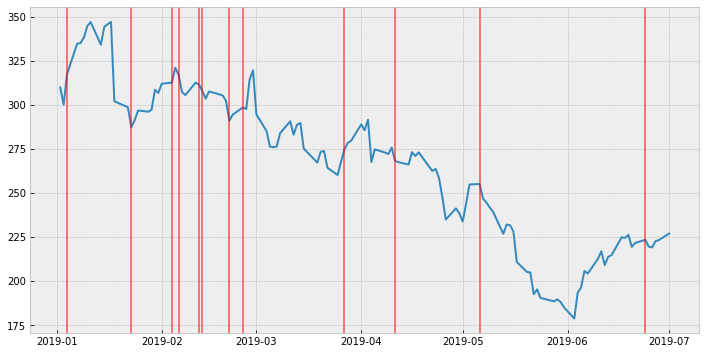

In [153]:
trades = []
for n in range(0,len(tesla_y_pred)):
    if tesla_y_pred[n] == 1:
        trades.append(str(tesla_y_test.index[n])[:10])

plt.figure(figsize=(12,6))
plt.plot(tesla_master[:'2019']['4. close'])
for trade in trades:
    plt.axvline(x=[trade], color='r', alpha=.5)

Lastly we'll go through the same process with Facebook. Two challenges with working with Facebook. First, is that for the NYT sentiment it could be a little hard to tease out which articles actually had to do with Facebook and which just happened to mention Facebook (every other article has a reference to something someone said on Facebook).

Second, unlike the other two companies here, from a financial perspective, Facebook is pretty well established from a financial perspective. You might expect that its stock performance would be more grounded in financials and less in general 'sentiment'... and you'd be right it seems.

In [149]:
facebook_master = pd.read_csv('facebook_master.csv')
facebook_master['date'] =  pd.to_datetime(facebook_master['date'])
facebook_master.set_index('date', inplace=True)
facebook_master = facebook_master['2019-06-19':]

facebook_master['above_average'] = [1 if facebook_master.iloc[n]['day_change']>.0005 else 0 
                                 for n in range(0,len(facebook_master))]
facebook_master['positive_return'] = [1 if facebook_master.iloc[n]['day_change']>.0 else 0 
                                 for n in range(0,len(facebook_master))]


features = ['nyt_compound','nyt_pos','nyt_neg','twitter_compound','twitter_pos','twitter_neg']
facebook_X_train = facebook_master['2018':'2016'][features]
facebook_X_test = facebook_master[:'2019'][features]
facebook_y_train = facebook_master['2018':'2016']['above_average']
facebook_y_test = facebook_master[:'2019']['above_average']

param_grid = { 
    'n_estimators': [10,20,30,40,50],
    'criterion': ['gini','entropy'],
    'max_depth': [1,2,3,4,5,6,7,8],
    'min_samples_leaf': [2,3,4,5,6,7,8,9,10]}

rfc = RandomForestClassifier(n_jobs=-1)


facebook_CV_rfc = GridSearchCV(rfc, param_grid, cv=8,n_jobs=-1,scoring='precision')
facebook_CV_rfc.fit(facebook_X_train, facebook_y_train)
facebook_CV_rfc.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 2,
 'n_estimators': 20}

In [152]:
facebook_y_pred = facebook_CV_rfc.predict(facebook_X_test)
print('Accuracy: ',accuracy_score(facebook_y_test,facebook_y_pred))
print('Recall: ',recall_score(facebook_y_test,facebook_y_pred))
print('Precision: ',precision_score(facebook_y_test,facebook_y_pred))
print('F1: ',f1_score(facebook_y_test,facebook_y_pred))

Accuracy:  0.42735042735042733
Recall:  0.45
Precision:  0.4426229508196721
F1:  0.44628099173553715


In [154]:
facebook_test_change= facebook_master[:'2019']['day_change']
earnings = 0
for n in range(0,len(facebook_y_pred)):
    if facebook_y_pred[n] == 1:
        earnings += (facebook_test_change.iloc[n]*1000)
earnings

82.42120289605157

In [155]:
initial = facebook_master[:'2019']['4. close'][-1]
final = facebook_master[:'2019']['4. close'][0]
(1000/initial)*final - 1000

381.78066037735834

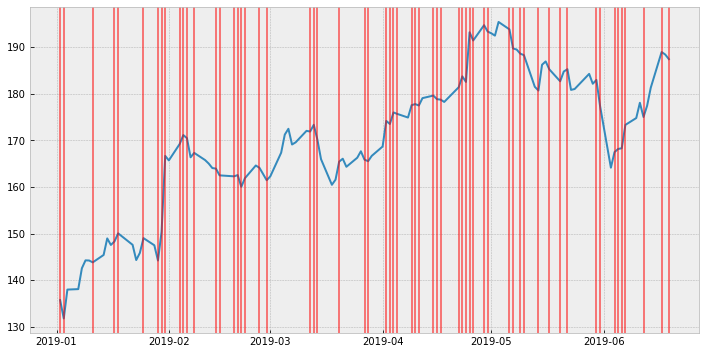

In [186]:
trades = []
for n in range(0,len(facebook_y_pred)):
    if facebook_y_pred[n] == 1:
        trades.append(str(facebook_y_test.index[n])[:10])

plt.figure(figsize=(12,6))
plt.plot(facebook_master[:'2019']['4. close'])
for trade in trades:
    plt.axvline(x=[trade], color='r', alpha=.5)

The strategy unambiguosly fails with Facebook - to what extent that is due to unclean data or to the fact that Facebook is more financially mature remains to be seen.

## Addenda: KNN and lags##

I'm curious to try a couple more strategies. The first using a KNN model, which my also be able to handle the non-linear relationships here. The second by introducing lagged sentiment values - that is the sentiment values from the previous period. Perhaps, for instance, two high or low sentiment days in a row is a strong signal than just one.

First to a simple KNN:

In [163]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=-1)
knn_params = {'n_neighbors':[1,3,5,7],
              'p':[1,2,3],
              'weights':['uniform','distance']}
tesla_CV_knn = GridSearchCV(knn, knn_params, cv=8,n_jobs=-1,scoring='recall')
tesla_CV_knn.fit(tesla_X_train, tesla_y_train)
tesla_CV_knn.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 1, 'p': 3, 'weights': 'uniform'}

In [162]:
tesla_y_pred_knn = tesla_CV_knn.predict(tesla_X_test)
print('Accuracy: ',accuracy_score(tesla_y_test,tesla_y_pred_knn))
print('Recall: ',recall_score(tesla_y_test,tesla_y_pred_knn))
print('Precision: ',precision_score(tesla_y_test,tesla_y_pred_knn))
print('F1: ',f1_score(tesla_y_test,tesla_y_pred_knn))
earnings = 0
for n in range(0,len(tesla_y_pred_knn)):
    if tesla_y_pred_knn[n] == 1:
        earnings += (tesla_test_change.iloc[n]*1000)
earnings

Accuracy:  0.52
Recall:  0.4918032786885246
Precision:  0.5084745762711864
F1:  0.4999999999999999


-81.23655020821633

In [166]:
netflix_CV_knn = GridSearchCV(knn, knn_params, cv=8,n_jobs=-1,scoring='recall')
netflix_CV_knn.fit(netflix_X_train, netflix_y_train)
netflix_CV_knn.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}

In [167]:
netflix_y_pred_knn = netflix_CV_knn.predict(netflix_X_test)
print('Accuracy: ',accuracy_score(netflix_y_test,netflix_y_pred_knn))
print('Recall: ',recall_score(netflix_y_test,netflix_y_pred_knn))
print('Precision: ',precision_score(netflix_y_test,netflix_y_pred_knn))
print('F1: ',f1_score(netflix_y_test,netflix_y_pred_knn))
earnings = 0
for n in range(0,len(netflix_y_pred_knn)):
    if netflix_y_pred_knn[n] == 1:
        earnings += (neflix_test_change.iloc[n]*1000)
earnings

Accuracy:  0.4032258064516129
Recall:  0.45454545454545453
Precision:  0.4411764705882353
F1:  0.4477611940298507


4.680165224666977

Well, those don't work at all!

Now let's add in some lags and see if they're useful...

In [168]:
def lag_maker(df,feature):
    temp_list = []
    for n in range(0,len(df)):
        if n<len(df)-1:
            temp_list.append(df[str(df.index[n+1])][feature][0])
        else:
            temp_list.append(0)
    return temp_list

for feature in features:
    tesla_master[f'{feature}_lag'] = lag_maker(tesla_master,feature)

In [169]:
tesla_master.head()

,1. open,2. high,3. low,4. close,5. volume,nyt_compound,nyt_pos,nyt_neg,twitter_compound,twitter_pos,...,week_change,rolling_sentiment,above_average,positive_return,nyt_compound_lag,nyt_pos_lag,nyt_neg_lag,twitter_compound_lag,twitter_pos_lag,twitter_neg_lag
date,,,,,,,,,,,,,,,,,,,,,
2019-07-01,230.21,233.0995,226.28,227.17,8237964,0.0,0.0,0.0,0.99990,0.17600,...,-0.011533,NaN,0,0,0.0,0.0,0.0,0.99985,0.16775,0.06575
2019-06-28,220.99,225.1700,220.80,223.46,6851384,0.0,0.0,0.0,0.99985,0.16775,...,0.016603,NaN,1,1,0.0,0.0,0.0,0.99950,0.16500,0.05800
2019-06-27,219.45,222.9000,217.35,222.84,6339710,0.0,0.0,0.0,0.99950,0.16500,...,0.002782,NaN,1,1,0.0,0.0,0.0,0.99970,0.16000,0.06200
2019-06-26,220.31,227.2300,218.10,219.27,8507208,0.0,0.0,0.0,0.99970,0.16000,...,0.016281,NaN,1,1,0.0,0.0,0.0,0.99730,0.11100,0.08200
2019-06-25,224.39,225.3400,219.49,219.76,6182071,0.0,0.0,0.0,0.99730,0.11100,...,-0.002230,0.0,0,0,0.0,0.0,0.0,0.99940,0.12600,0.04800


In [176]:
lag_features = features + [f'{feature}_lag' for feature in features]
tesla_lag_X_train = tesla_master['2018':'2016'][lag_features]
tesla_lag_X_test = tesla_master[:'2019'][lag_features]
tesla_lag_y_train = tesla_master['2018':'2016']['above_average']
tesla_lag_y_test = tesla_master[:'2019']['above_average']

tesla_lag_CV_rfc = GridSearchCV(rfc, param_grid, cv=8,n_jobs=-1,scoring='recall')
tesla_lag_CV_rfc.fit(tesla_lag_X_train, tesla_lag_y_train)
tesla_lag_CV_rfc.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 2,
 'n_estimators': 10}

In [177]:
tesla_lag_y_pred = tesla_lag_CV_rfc.predict(tesla_lag_X_test)
print('Accuracy: ',accuracy_score(tesla_y_test,tesla_lag_y_pred))
print('Recall: ',recall_score(tesla_y_test,tesla_lag_y_pred))
print('Precision: ',precision_score(tesla_y_test,tesla_lag_y_pred))
print('F1: ',f1_score(tesla_y_test,tesla_lag_y_pred))
earnings = 0
for n in range(0,len(tesla_lag_y_pred)):
    if tesla_lag_y_pred[n] == 1:
        earnings += (tesla_test_change.iloc[n]*1000)
earnings

Accuracy:  0.512
Recall:  0.06557377049180328
Precision:  0.5
F1:  0.11594202898550726


39.82292230285222

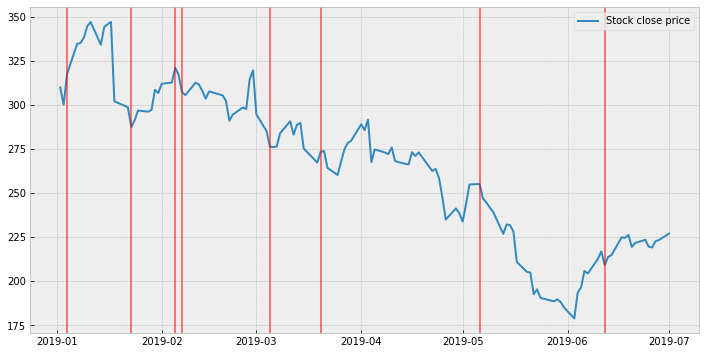

In [209]:
trades = []
for n in range(0,len(tesla_lag_y_pred)):
    if tesla_lag_y_pred[n] == 1:
        trades.append(str(tesla_y_test.index[n])[:10])

plt.figure(figsize=(12,6))
plt.plot(tesla_master[:'2019']['4. close'],label='Stock close price')
for trade in trades:
    plt.axvline(x=[trade], color='r', alpha=.5)
plt.legend()

In [184]:
for feature in features:
    netflix_master[f'{feature}_lag'] = lag_maker(netflix_master,feature)
    
netflix_lag_X_train = netflix_master['2018':'2016'][lag_features]
netflix_lag_X_test = netflix_master[:'2019'][lag_features]
netflix_lag_y_train = netflix_master['2018':'2016']['above_average']
netflix_lag_y_test = netflix_master[:'2019']['above_average']

netflix_lag_CV_rfc = GridSearchCV(rfc, param_grid, cv=8,n_jobs=-1,scoring='f1')
netflix_lag_CV_rfc.fit(netflix_lag_X_train, netflix_lag_y_train)
netflix_lag_CV_rfc.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 2,
 'n_estimators': 10}

In [185]:
netflix_y_pred_lag = netflix_lag_CV_rfc.predict(netflix_lag_X_test)
print('Accuracy: ',accuracy_score(netflix_y_test,netflix_y_pred_lag))
print('Recall: ',recall_score(netflix_y_test,netflix_y_pred_lag))
print('Precision: ',precision_score(netflix_y_test,netflix_y_pred_lag))
print('F1: ',f1_score(netflix_y_test,netflix_y_pred_lag))
earnings = 0
for n in range(0,len(netflix_y_pred_lag)):
    if netflix_y_pred_lag[n] == 1:
        earnings += (neflix_test_change.iloc[n]*1000)
earnings

Accuracy:  0.49193548387096775
Recall:  0.5151515151515151
Precision:  0.5230769230769231
F1:  0.5190839694656489


208.57319928528182

Adding the lags doesn't appear to add a whole lot... I think I lucked into a Tesla model that worked slightly better, Netflix doesn't work quite as well.

## Addenda number 2: Amazon##

One final master dataframe has finished processing, Amazon. Can a useful model be built for Amazon? Doesn't seem like it!

In [204]:
amazon_master = pd.read_csv('amazon_master.csv')
amazon_master['date'] =  pd.to_datetime(amazon_master['date'])
amazon_master.set_index('date', inplace=True)
amazon_master = amazon_master['2019-06-19':]

amazon_master['above_average'] = [1 if amazon_master.iloc[n]['day_change']>.0005 else 0 
                                 for n in range(0,len(amazon_master))]
amazon_master['positive_return'] = [1 if amazon_master.iloc[n]['day_change']>.0 else 0 
                                 for n in range(0,len(amazon_master))]


features = ['nyt_compound','nyt_pos','nyt_neg','twitter_compound','twitter_pos','twitter_neg']
amazon_X_train = amazon_master['2018':'2016'][features]
amazon_X_test = amazon_master[:'2019'][features]
amazon_y_train = amazon_master['2018':'2016']['above_average']
amazon_y_test = amazon_master[:'2019']['above_average']

param_grid = { 
    'n_estimators': [10,20,30,40,50],
    'criterion': ['gini','entropy'],
    'max_depth': [1,2,3,4,5,6,7,8],
    'min_samples_leaf': [2,3,4,5,6,7,8,9,10]}

rfc = RandomForestClassifier(n_jobs=-1)


amazon_CV_rfc = GridSearchCV(rfc, param_grid, cv=8,n_jobs=-1,scoring='accuracy')
amazon_CV_rfc.fit(amazon_X_train, amazon_y_train)
amazon_CV_rfc.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 6,
 'n_estimators': 50}

In [205]:
amazon_y_pred = amazon_CV_rfc.predict(amazon_X_test)
print('Accuracy: ',accuracy_score(amazon_y_test,amazon_y_pred))
print('Recall: ',recall_score(amazon_y_test,amazon_y_pred))
print('Precision: ',precision_score(amazon_y_test,amazon_y_pred))
print('F1: ',f1_score(amazon_y_test,amazon_y_pred))
amazon_test_change= amazon_master[:'2019']['day_change']
earnings = 0
for n in range(0,len(amazon_y_pred)):
    if amazon_y_pred[n] == 1:
        earnings += (amazon_test_change.iloc[n]*1000)
earnings

Accuracy:  0.5555555555555556
Recall:  0.8181818181818182
Precision:  0.574468085106383
F1:  0.675


172.37667436337307

In [206]:
initial = amazon_master[:'2019']['4. close'][-1]
final = amazon_master[:'2019']['4. close'][0]
(1000/initial)*final - 1000

240.17464411713104

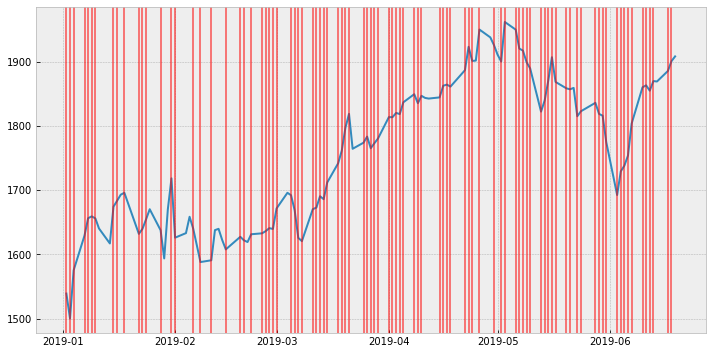

In [207]:
trades = []
for n in range(0,len(amazon_y_pred)):
    if amazon_y_pred[n] == 1:
        trades.append(str(amazon_y_test.index[n])[:10])

plt.figure(figsize=(12,6))
plt.plot(amazon_master[:'2019']['4. close'])
for trade in trades:
    plt.axvline(x=[trade], color='r', alpha=.5)